# Experiments on the small business administration dataset

temporal shift


In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, make_scorer
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve

pd.options.display.max_columns = 100
pd.options.display.max_rows = 150

import warnings

warnings.filterwarnings('ignore')
from utilexp import *
from expnns.preprocessor import min_max_scale

In [2]:

df = pd.read_csv("../datasets/sba/SBAcase.11.13.17.csv", delimiter=',')
df = df.dropna(axis=1)
df = df.drop(columns=['ApprovalDate', "LoanNr_ChkDgt", "Name", "Zip", "City", "State", "NAICS", "FranchiseCode", 'BalanceGross', "MIS_Status", "Selected", "UrbanRural", 'Recession', 'New', 'RealEstate'])
continuous_features = ['Term', 'NoEmp', 'CreateJob', 'RetainedJob',
       'DisbursementGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv', 'Portion',
       'daysterm']

df1 = df[df['ApprovalFY'] < 2006].drop(columns="ApprovalFY")
df2 = df[df['ApprovalFY'] >= 2006].drop(columns="ApprovalFY")
df = df.drop(columns=["ApprovalFY"])
# min max scale
min_vals = np.min(df[continuous_features], axis=0)
max_vals = np.max(df[continuous_features], axis=0)
df1_mm = min_max_scale(df1, continuous_features, min_vals, max_vals)
df2_mm = min_max_scale(df2, continuous_features, min_vals, max_vals)

# get X, y
X1, y1 = df1_mm.drop(columns=['Default']), pd.DataFrame(1 - df1_mm['Default'])
X2, y2 = df2_mm.drop(columns=['Default']), pd.DataFrame(1 - df2_mm['Default'])
SPLIT = .2
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, stratify=y1, test_size=SPLIT, shuffle=True,
                                                    random_state=0)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, stratify=y2, test_size=SPLIT, shuffle=True,
                                                    random_state=0)

ordinal_features = {}
discrete_features = {}
columns = list(df1_mm.columns)
feat_var_map = {}
for i in range(len(X1.columns)):
    feat_var_map[i] = [i]


In [3]:
for item in continuous_features:
    print(np.min(df1_mm[item]), np.min(df2_mm[item]), np.max(df1_mm[item]), np.max(df2_mm[item]))

0.0032679738562091504 0.0 1.0 0.9803921568627451
0.0015384615384615385 0.0 1.0 0.5307692307692308
0.0 0.0 1.0 0.7692307692307693
0.0 0.0 1.0 0.2803738317757009
0.0 7.142346975216056e-05 0.8636461032004208 1.0
0.0 0.0 0.8314895167434003 1.0
0.00021317416329140907 0.0 0.8507780856960137 1.0
0.00011832919181161993 0.0 0.9450952549994084 1.0
0.0 0.14679407875090658 1.0 1.0
0.0032679738562091504 0.0 1.0 0.9803921568627451


# Train and observe model changes

In [61]:
# Randomdised search + 5-fold cross validation (default)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier

nn = MLPClassifier(learning_rate='adaptive', random_state=0)

# parameters
max_iter_vals = [int(i) for i in np.linspace(1000, 10000, 10)]
hidden_layer_sizes_vals = [(i) for i in range(5, 25)]
batch_size_vals = [8, 16, 32, 64]
learning_rate_init_vals = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05]

#distributions = dict(max_iter=max_iter_vals, hidden_layer_sizes=hidden_layer_sizes_vals)
distributions = dict(hidden_layer_sizes=hidden_layer_sizes_vals,
                     batch_size=batch_size_vals,
                     learning_rate_init=learning_rate_init_vals,
                     max_iter=max_iter_vals, )

#nns = RandomizedSearchCV(nn, distributions, scoring='f1_macro')
nns = RandomizedSearchCV(nn, distributions, scoring='accuracy')
search = nns.fit(X1, y1)
print(search.best_params_)


{'max_iter': 9000, 'learning_rate_init': 0.005, 'hidden_layer_sizes': 18, 'batch_size': 8}


In [63]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(learning_rate='adaptive', hidden_layer_sizes=18, learning_rate_init=0.005, batch_size=8,
                    max_iter=9000, random_state=0)

# 5-fold cross validation
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score, f1_score, precision_score

scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
scores = cross_validate(clf, X1, y1, scoring=scoring)
for name in list(scores.keys()):
    if name == 'fit_time' or name == 'score_time':
        continue
    print("%0.2f %s with a std of %0.2f" % (scores[name].mean(), name, scores[name].std()))

clf = MLPClassifier(learning_rate='adaptive', hidden_layer_sizes=18, learning_rate_init=0.005, batch_size=8,
                    max_iter=9000, random_state=0)

clf.fit(X1_train, y1_train)
resres = clf.predict(X1_test.values)
print('\n', classification_report(y1_test, resres, target_names=[f'bad credit (0)', f'good credit (1)'], digits=3))
resres = clf.predict(X1_train.values)
print('\n', classification_report(y1_train, resres, target_names=[f'bad credit (0)', f'good credit (1)'], digits=3))


0.99 test_accuracy with a std of 0.01
0.98 test_precision_macro with a std of 0.02
0.97 test_recall_macro with a std of 0.03
0.98 test_f1_macro with a std of 0.02

                  precision    recall  f1-score   support

 bad credit (0)      0.923     0.973     0.947        37
good credit (1)      0.995     0.985     0.990       195

       accuracy                          0.983       232
      macro avg      0.959     0.979     0.969       232
   weighted avg      0.983     0.983     0.983       232


                  precision    recall  f1-score   support

 bad credit (0)      0.955     0.993     0.974       149
good credit (1)      0.999     0.991     0.995       778

       accuracy                          0.991       927
      macro avg      0.977     0.992     0.984       927
   weighted avg      0.992     0.991     0.991       927



In [64]:
resres = clf.predict(X1_test.values)
print('\n', classification_report(y1_test, resres, target_names=[f'bad credit (0)', f'good credit (1)'], digits=3))
resres = clf.predict(X1_train.values)
print('\n', classification_report(y1_train, resres, target_names=[f'bad credit (0)', f'good credit (1)'], digits=3))



                  precision    recall  f1-score   support

 bad credit (0)      0.923     0.973     0.947        37
good credit (1)      0.995     0.985     0.990       195

       accuracy                          0.983       232
      macro avg      0.959     0.979     0.969       232
   weighted avg      0.983     0.983     0.983       232


                  precision    recall  f1-score   support

 bad credit (0)      0.955     0.993     0.974       149
good credit (1)      0.999     0.991     0.995       778

       accuracy                          0.991       927
      macro avg      0.977     0.992     0.984       927
   weighted avg      0.992     0.991     0.991       927



In [65]:
# save the trained classifier
from joblib import dump, load

#dump(clf, 'sba.joblib')


['sba.joblib']

# Experiments: computing counterfactuals

#### Procedures

These procedures are covered by UtilExp class

1. Train M on D1
2. Get delta-min, build M+ and M-: incrementally train M 5 times, using different 10% of D2 each time, then get the maximum inf-distance between the incremented models and M. Construct M+ and M- using delta-min
3. Get M2: incrementally train M on D2
4. Select test instances: randomly select 50 D1 instances to explain, clf(x)=0, desired class=1
5. Report metrics using each baseline

#### Metrics
- Proximity: normalised L1: "Scaling Guarantees for Nearest CEs" page 7
- Sparsity: L0
- Validity-delta: percentage of test instances that 1) have counterfactuals valid on m1, 2) counterfactuals valid on M+ and M- under delta_min
- Validity-m2: percentage of test instances that 1) have counterfactual(s), 2) these counterfactual(s) are all valid on both m1 and m2
- LOF: average LOF score

In [4]:
from joblib import dump, load
import gurobipy
clf = load("sba.joblib")
gurobipy.setParam("FeasibilityTol", 1e-09)
gurobipy.setParam("OptimalityTol", 1e-09)
gurobipy.setParam("IntFeasTol", 1e-05)


Set parameter Username
Academic license - for non-commercial use only - expires 2023-06-14
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09


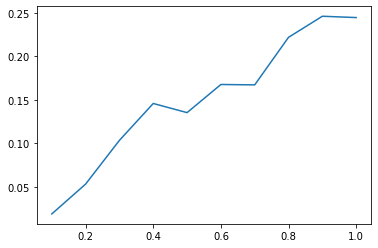

In [5]:
gaps = np.arange(0.1, 1.01, 0.1)
deltas = []
clfs = []
for a, i in enumerate(gaps):
    clfs.append(copy.deepcopy(clf))
    util_exp = UtilExp(clfs[a], X1, y1, X2, y2, columns, ordinal_features, discrete_features, continuous_features, feat_var_map,
                   num_test_instances=1000, gap=i)
    deltas.append(util_exp.delta_min)
plt.plot(gaps, deltas)

In [17]:
util_exp = UtilExp(clf, X1, y1, X2, y2, columns, ordinal_features, discrete_features, continuous_features, feat_var_map, gap=0.5, num_test_instances=1000)
print(util_exp.delta_max)
print(util_exp.delta_min)

0.24710181070706494
0.135305282370637


In [18]:
print(len(X1.values) - np.sum(clf.predict(X1)))

194


In [19]:
valids = util_exp.verify_soundness()
print(len(valids))

percentage of sound model changes: 0.5
97


In [20]:
valids = util_exp.verify_soundness(update_test_instances=True)
valids2 = util_exp.verify_soundness()   # percentage should be 1
print(len(valids))

percentage of sound model changes: 0.5
test instances updated to sound (x, Delta) pairs, length: 50
percentage of sound model changes: 1.0
50


In [21]:
# OURS-ROBUST
ours_robust_ces = util_exp.run_ours_robust()
util_exp.evaluate_ces(ours_robust_ces)

50it [01:00,  1.21s/it]


total computation time in s: 60.74400043487549
found: 1.0
average normalised L1: 0.030654831528075698
average normalised L0: 0.27800000000000014
average lof score: -1.0
counterfactual validity: 1.0
delta validity: 1.0
m2 validity: 1.0


In [14]:
# OURS-NON-ROBUST
ours_non_robust_ces = util_exp.run_ours_non_robust()
util_exp.evaluate_ces(ours_non_robust_ces)

50it [00:00, 73.85it/s]


total computation time in s: 0.6790058612823486
found: 1.0
average normalised L1: 0.006000114301707776
average normalised L0: 0.10199999999999995
average lof score: 0.68
counterfactual validity: 1.0
delta validity: 0.0
m2 validity: 0.26


In [22]:
# ROAR
roar_ces = util_exp.run_ROAR(labels=(1,))
util_exp.evaluate_ces(roar_ces)

0it [00:00, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  6.33it/s]

0it [00:00, ?it/s]
1it [00:00,  6.10it/s]

0it [00:00, ?it/s]
1it [00:00,  6.67it/s]

0it [00:00, ?it/s]
1it [00:00,  6.71it/s]

0it [00:00, ?it/s]
1it [00:00,  6.06it/s]

0it [00:00, ?it/s]
1it [00:00,  9.01it/s]

0it [00:00, ?it/s]
1it [00:00,  8.33it/s]

1it [00:00, 27.09it/s]
1it [00:01,  1.19s/it]
0it [00:00, ?it/s]
1it [00:00,  7.04it/s]

0it [00:00, ?it/s]
1it [00:00,  7.25it/s]

0it [00:00, ?it/s]
1it [00:00,  7.52it/s]

0it [00:00, ?it/s]
1it [00:00,  7.81it/s]

0it [00:00, ?it/s]
1it [00:00,  7.04it/s]

0it [00:00, ?it/s]
1it [00:00,  8.85it/s]

1it [00:00, 26.34it/s]
2it [00:02,  1.06s/it]
0it [00:00, ?it/s]
1it [00:00,  5.38it/s]

0it [00:00, ?it/s]
1it [00:00,  5.58it/s]

0it [00:00, ?it/s]
1it [00:00,  5.68it/s]

0it [00:00, ?it/s]
1it [00:00,  5.88it/s]

0it [00:00, ?it/s]
1it [00:00,  5.71it/s]

0it [00:00, ?it/s]
1it [00:00,  7.19it/s]

0it [00:00, ?it/s]
1it [00:00,  7.87it/s]

0it [00:00, ?it/s]
1it [00:00

total computation time in s: 66.88477325439453
found: 1.0
average normalised L1: 0.008555785672608042
average normalised L0: 0.668181818181818
average lof score: -0.22727272727272727
counterfactual validity: 0.88
delta validity: 0.6
m2 validity: 0.88


In [15]:
# ROAR-robustness-boosted
roar_ces = util_exp.run_ROAR(labels=(1,), robust=True, lamb1_mul=2)
util_exp.evaluate_ces(roar_ces)
# lamb1 *= 2, count 10

0it [00:00, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  2.23it/s]

0it [00:00, ?it/s]
1it [00:00,  2.11it/s]

0it [00:00, ?it/s]
1it [00:00,  2.42it/s]

0it [00:00, ?it/s]
1it [00:00,  2.18it/s]

0it [00:00, ?it/s]
1it [00:00,  2.27it/s]

0it [00:00, ?it/s]
1it [00:00,  2.46it/s]

0it [00:00, ?it/s]
1it [00:00,  2.65it/s]

0it [00:00, ?it/s]
1it [00:00,  3.22it/s]

0it [00:00, ?it/s]
1it [00:00,  4.05it/s]

0it [00:00, ?it/s]
1it [00:00,  3.76it/s]

0it [00:00, ?it/s]
1it [00:00,  3.64it/s]

0it [00:00, ?it/s]
1it [00:00,  4.98it/s]
1it [00:33, 33.28s/it]
0it [00:00, ?it/s]
1it [00:00,  1.79it/s]

0it [00:00, ?it/s]
1it [00:00,  1.83it/s]

0it [00:00, ?it/s]
1it [00:00,  1.93it/s]

0it [00:00, ?it/s]
1it [00:00,  1.66it/s]

0it [00:00, ?it/s]
1it [00:00,  1.43it/s]

0it [00:00, ?it/s]
1it [00:00,  1.85it/s]

0it [00:00, ?it/s]
1it [00:00,  1.91it/s]

0it [00:00, ?it/s]
1it [00:00,  1.70it/s]

0it [00:00, ?it/s]
1it [00:00,  2.21it/s]

0it [00:00, ?it/s]
1it [00:00,  2.20it/s]

0it [00:00, ?

total computation time in s: 321.46596455574036
found: 1.0
average normalised L1: 0.07246740897968075
average normalised L0: 0.966
average lof score: 1.0
counterfactual validity: 0.1
delta validity: 0.0
m2 validity: 0.0


In [23]:
# PROTOTYPES
proto_ces = util_exp.run_proto()
util_exp.evaluate_ces(proto_ces)

No encoder specified. Using k-d trees to represent class prototypes.
2it [00:32, 16.05s/it]No counterfactual found!
4it [01:05, 16.28s/it]No counterfactual found!
8it [02:09, 15.93s/it]No counterfactual found!
11it [02:56, 15.77s/it]No counterfactual found!
18it [04:49, 16.06s/it]No counterfactual found!
19it [05:07, 16.54s/it]No counterfactual found!
25it [06:42, 15.90s/it]No counterfactual found!
30it [08:03, 15.95s/it]No counterfactual found!
33it [08:50, 15.75s/it]No counterfactual found!
37it [09:52, 15.50s/it]No counterfactual found!
45it [12:00, 16.11s/it]No counterfactual found!
50it [13:22, 16.04s/it]


total computation time in s: 802.1430425643921
found: 0.78
average normalised L1: 0.006262885289763952
average normalised L0: 0.12307692307692303
average lof score: 0.5897435897435898
counterfactual validity: 0.78
delta validity: 0.0
m2 validity: 0.1


In [6]:
# PROTOTYPES-robustness-boosted
proto_ces_robust= util_exp.run_proto_robust(proto_ces)
util_exp.evaluate_ces(proto_ces_robust)

0it [00:00, ?it/s]No encoder specified. Using k-d trees to represent class prototypes.
No encoder specified. Using k-d trees to represent class prototypes.
No encoder specified. Using k-d trees to represent class prototypes.
No encoder specified. Using k-d trees to represent class prototypes.
No encoder specified. Using k-d trees to represent class prototypes.
No encoder specified. Using k-d trees to represent class prototypes.
No encoder specified. Using k-d trees to represent class prototypes.
No encoder specified. Using k-d trees to represent class prototypes.
No encoder specified. Using k-d trees to represent class prototypes.
No encoder specified. Using k-d trees to represent class prototypes.
No encoder specified. Using k-d trees to represent class prototypes.
1it [02:23, 143.95s/it]No encoder specified. Using k-d trees to represent class prototypes.
No encoder specified. Using k-d trees to represent class prototypes.
No encoder specified. Using k-d trees to represent class proto

total computation time in s: 1524.6610071659088
found: 1.0
average normalised L1: 0.4533255552214787
average normalised L0: 0.8898999999999999
average lof score: -0.4
counterfactual validity: 1.0
delta validity: 0.0
m2 validity: 1.0


In [54]:
# WACHTER CF
wachter_ces = util_exp.run_wachter(target_proba=1, max_lam_steps=10, lam_init=0.02)
util_exp.evaluate_ces(wachter_ces)


4it [00:07,  1.96s/it]No appropriate lambda range found, try decreasing lam_init
8it [00:15,  1.91s/it]No appropriate lambda range found, try decreasing lam_init
19it [00:34,  1.73s/it]No appropriate lambda range found, try decreasing lam_init
30it [00:53,  1.76s/it]No appropriate lambda range found, try decreasing lam_init
33it [00:57,  1.65s/it]No appropriate lambda range found, try decreasing lam_init
45it [01:18,  1.82s/it]No appropriate lambda range found, try decreasing lam_init
50it [01:27,  1.75s/it]


total computation time in s: 87.63580203056335
found: 0.88
average normalised L1: 0.01143503459191448
average normalised L0: 0.9136363636363634
average lof score: -0.045454545454545456
counterfactual validity: 0.88
delta validity: 0.0
m2 validity: 0.88


In [29]:
delta = util_exp.delta_min
print(np.arange(delta / 10, delta * 1.01, delta / 10))
plot_x = np.arange(0.1, 1.01, 0.1)
print(delta)
print(plot_x)


[0.01353053 0.02706106 0.04059158 0.05412211 0.06765264 0.08118317
 0.0947137  0.10824423 0.12177475 0.13530528]
0.135305282370637
[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [30]:
def evaluate_ces_validity_plot(test_instances, ces, target_delta=0.05):
    deltas = np.concatenate((np.array([0]),np.arange(target_delta/10, target_delta*1.01, target_delta/10)))
    delta_vals = []
    for delta in deltas:
        delta_val = 0
        nodes = build_inn_nodes(util_exp.clf, util_exp.num_layers)
        weights, biases = build_inn_weights_biases(util_exp.clf, util_exp.num_layers, delta, nodes)
        inn_delta = Inn(util_exp.num_layers, delta, nodes, weights, biases)
        for i, x in enumerate(test_instances):
            if ces[i] is None:
                continue
            y_prime = 1 if util_exp.clf.predict(x.reshape(1, -1))[0] == 0 else 0
            this_solver = OptSolver(util_exp.dataset, inn_delta, y_prime, x, mode=1, M=10000, x_prime=ces[i])
            if this_solver.compute_inn_bounds()[0] == 1:
                delta_val += 1
        delta_vals.append(delta_val / len(test_instances))
    return delta_vals


In [37]:
delta_vals_roar = evaluate_ces_validity_plot(util_exp.test_instances, roar_ces, target_delta=util_exp.delta_min)
delta_vals_ours_non_rob = evaluate_ces_validity_plot(util_exp.test_instances, ours_non_robust_ces,
                                                     target_delta=util_exp.delta_min)
delta_vals_wachter = evaluate_ces_validity_plot(util_exp.test_instances, wachter_ces, target_delta=util_exp.delta_min)
delta_vals_proto = evaluate_ces_validity_plot(util_exp.test_instances, proto_ces, target_delta=util_exp.delta_min)

In [38]:
plot_x = [str(i) + "*$\delta$" for i in np.round(np.arange(0., 1.00001, 0.1), 1)]
print(plot_x)
plot_x_num = np.round(np.arange(0, 1.00001, 0.1), 1)

['0.0*$\\delta$', '0.1*$\\delta$', '0.2*$\\delta$', '0.3*$\\delta$', '0.4*$\\delta$', '0.5*$\\delta$', '0.6*$\\delta$', '0.7*$\\delta$', '0.8*$\\delta$', '0.9*$\\delta$', '1.0*$\\delta$']


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


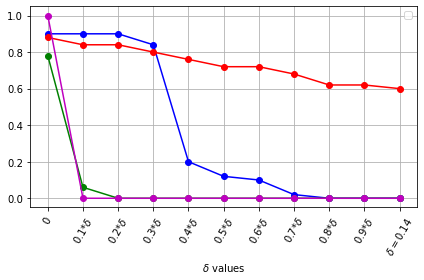

In [57]:
fig, ax = plt.subplots()
ax.plot(plot_x_num, delta_vals_wachter, "bo-")#, label="WACHTER")
ax.plot(plot_x_num, delta_vals_proto, "go-")#, label="PROTO")
ax.plot(plot_x_num, delta_vals_roar, "ro-")#, label="ROAR")
ax.plot(plot_x_num, delta_vals_ours_non_rob, "mo-")#, label="MILP")
ax.set_xticks(np.arange(0., 1.01, 0.1))
labels = [item.get_text() for item in ax.get_xticklabels()]
for i in range(len(labels)):
    labels[i] = plot_x[i]
    if i == len(labels) - 1:
        labels[i] = "$\delta=$" + str(np.round(util_exp.delta_min, 2))
    if i == 0:
        labels[i] = str(0)
ax.set_xticklabels(labels)
ax.grid()
ax.legend()
plt.xticks(rotation=60)
#ax.set_ylabel("$\delta$-validity")
ax.set_xlabel("$\delta$ values")
fig.tight_layout()
fig.savefig("./plots/delta-val-sba.png", dpi=300)